In [50]:
# !pip install python-docx

In [51]:
from docx import Document
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import matplotlib.pyplot as plt
import networkx as nx
import jieba
import numpy as np
from collections import defaultdict
import json
import pandas as pd
import community as community_louvain

# **Pre Processing**
**Remove all Symbols from docx**

In [52]:
# remove all symbols from docx

# this function used regular expression to abstract all the English words
def clean_docx (doc_path):
    doc = Document(doc_path)
    full_text = []

    # abstract text
    for p in doc.paragraphs:
        full_text.append(p.text)
    full_text = ' '.join(full_text)

    # regular expression
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', full_text)
    return cleaned_text

cleaned_text = clean_docx('project file.docx')
# doc = Document()
# doc.add_paragraph(cleaned_text)
# doc.save('Cleaned Project Text.docx')
# cleaned_text

**Remove all Stopwords and Put all Words in Lowercase**

In [53]:
# remove all stopwords

doc = Document('stopwords.docx')
stopwords = set(p.text.strip().lower() for p in doc.paragraphs if p.text.strip())
tokens = cleaned_text.split()
filtered_tokens = [word for word in tokens if word.lower() not in stopwords]
cleaned = " ".join(filtered_tokens).lower()
# doc = Document()
# doc.add_paragraph(cleaned_text)
# doc.save('Cleaned Project Text (not Lemmatizer).docx')
# cleaned

In [54]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Lemmatization**

In [55]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [56]:
# as there are different part of speech for each words
lemmatizer = WordNetLemmatizer()
tokens = nltk.word_tokenize(cleaned)
# try to find different part of speech
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# tag
tagged_tokens = pos_tag(tokens)
lemmatized_text = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
l_cleaned = " ".join(lemmatized_text)
# lemmatized_text

# **Complex Network Analysis**

**Generate Adjacency List**

In [57]:
# generate adjacency list

words = l_cleaned.split()
# adjacency list
a_list = defaultdict(set)
for i in range(len(words) - 1):
    word1 = words[i]
    word2 = words[i + 1]
    # no self-loop
    if word1 != word2:
        a_list[word1].add(word2)
        a_list[word2].add(word1)
a_list = dict(a_list)
# a_list

In [58]:
# # output adjacency list
# # to list
# normal_dict = {key: list(value) for key, value in a_list.items()}
# json_str = json.dumps(normal_dict, indent=4, sort_keys=True)
# a_str = json_str.replace('},', '},\n')
# # output
# with open('output.txt', 'w') as file:
#     file.write(a_str)

**Genrate Directed Graph**

H is the subgraph of G with specific conditions

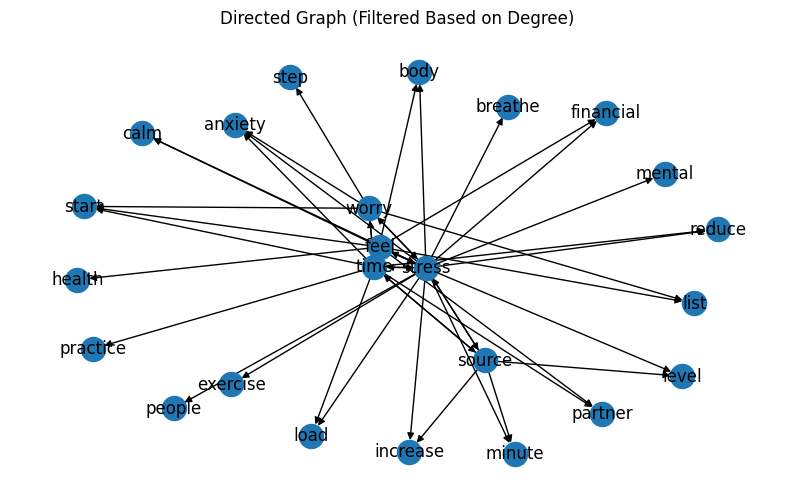

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()
for word, neighbors in a_list.items():
    for neighbor in neighbors:
        G.add_edge(word, neighbor)  # Adds a directed edge from 'word' to 'neighbor'

# Generate a subgraph with specific conditions
H = nx.DiGraph()
for node in G.nodes():
    if G.degree(node) >= 100:  # Checking the total degree (in-degree + out-degree)
        H.add_node(node)
        for neighbor in G[node]:
            if G.degree(neighbor) >= 50:
                H.add_edge(node, neighbor)  # Adds a directed edge, respects direction

# Plot the directed graph
plt.figure(figsize=(10, 6))
plt.title('Directed Graph (Filtered Based on Degree)')
nx.draw_networkx(H, with_labels=True, node_size=300, arrowstyle='-|>', arrowsize=10)
plt.axis('off')
plt.show()


**Genrate Undirected Graph**

H_u is the subgraph of G_u with specific conditions

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:312: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


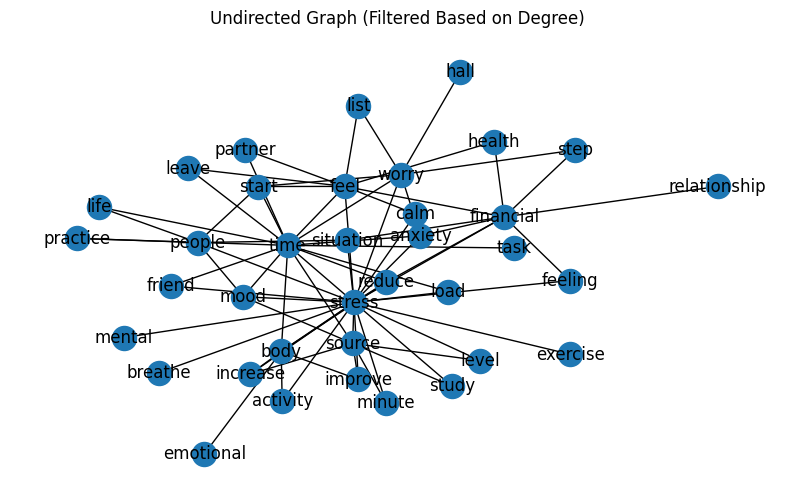

In [60]:
G_u = G.to_undirected()

# Generate a sub-network with specific conditions
H_u = nx.Graph()
for node in G_u.nodes():
    if G_u.degree(node) >= 40:  # Checking the total degree (in-degree + out-degree)
        H_u.add_node(node)
        for neighbor in G_u[node]:
            if G_u.degree(neighbor) >= 20:
                H_u.add_edge(node, neighbor)  # Adds a directed edge, respects direction

# Plot the undirected graph
plt.figure(figsize=(10, 6))
plt.title('Undirected Graph (Filtered Based on Degree)')
nx.draw_networkx(H_u, with_labels=True, node_size=300, arrowstyle='-|>', arrowsize=10)
plt.axis('off')
plt.show()

In [61]:
print("Number of nodes in H_u:", H_u.number_of_nodes())
print("Number of edges in H_u:", H_u.number_of_edges())

Number of nodes in H_u: 37
Number of edges in H_u: 74


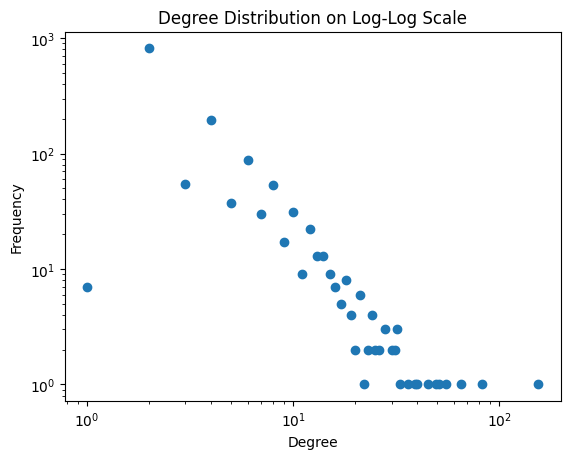

In [62]:
from collections import Counter

degrees = [degree for node, degree in G_u.degree()]

degree_count = Counter(degrees)
deg, cnt = zip(*degree_count.items())
fig, ax = plt.subplots()
ax.plot(deg, cnt, marker='o', linestyle='None')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Degree')
ax.set_ylabel('Frequency')
ax.set_title('Degree Distribution on Log-Log Scale')

plt.show()

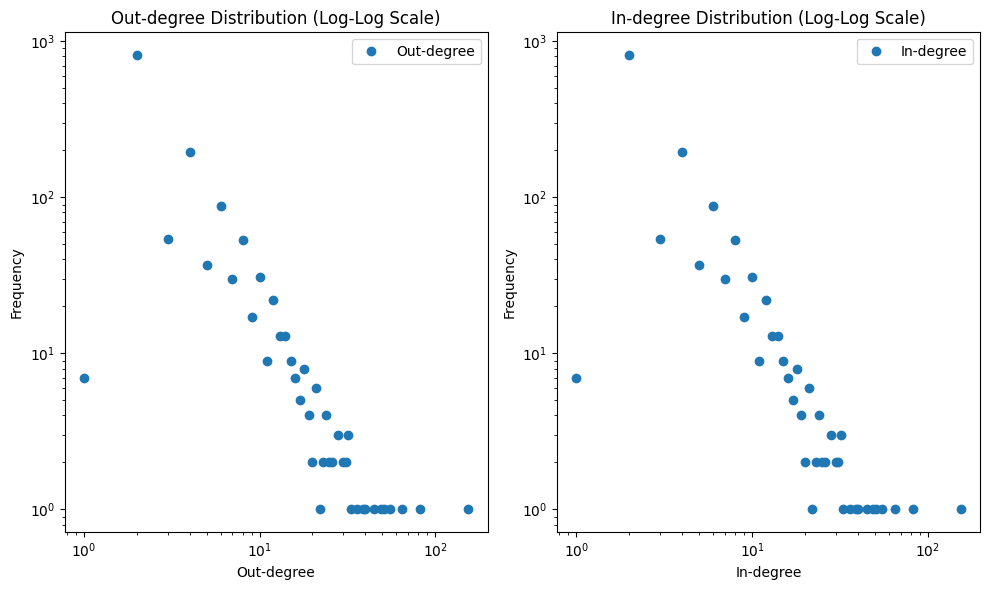

In [63]:
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())

# frequency distribution of in and out degree
out_degree_count = Counter(out_degrees.values())
in_degree_count = Counter(in_degrees.values())
out_deg, out_cnt = zip(*out_degree_count.items())
in_deg, in_cnt = zip(*in_degree_count.items())

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(out_deg, out_cnt, marker='o', linestyle='None', label='Out-degree')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Out-degree')
ax1.set_ylabel('Frequency')
ax1.set_title('Out-degree Distribution (Log-Log Scale)')
ax1.legend()

ax2.plot(in_deg, in_cnt, marker='o', linestyle='None', label='In-degree')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('In-degree')
ax2.set_ylabel('Frequency')
ax2.set_title('In-degree Distribution (Log-Log Scale)')
ax2.legend()

plt.tight_layout()
plt.show()

In [64]:
#network based on frequency
import nltk, re # load our required modules
from nltk.corpus import gutenberg # load the gutenberg corpus from nltk
from nltk.corpus import stopwords
from collections import Counter
stop_words = set(stopwords.words('english'))
stress_stopped=[]
for word in tokens:
  if word not in stop_words:
      stress_stopped.append(word)

mostcommon=Counter(stress_stopped).most_common(44)
# print(mostcommon)
commonwords=[]
for (word,count) in mostcommon:
  commonwords.append(word)
# print(commonwords)
F=nx.Graph()
for node1 in G.nodes():
  for node2 in G.nodes():
    if node1 in commonwords and node2 in commonwords:
      if G.has_edge(node1, node2):
        F.add_edge(node1, node2)

print("Number of nodes in F:", F.number_of_nodes())
print("Number of edges in F:", F.number_of_edges())

Number of nodes in F: 37
Number of edges in F: 109


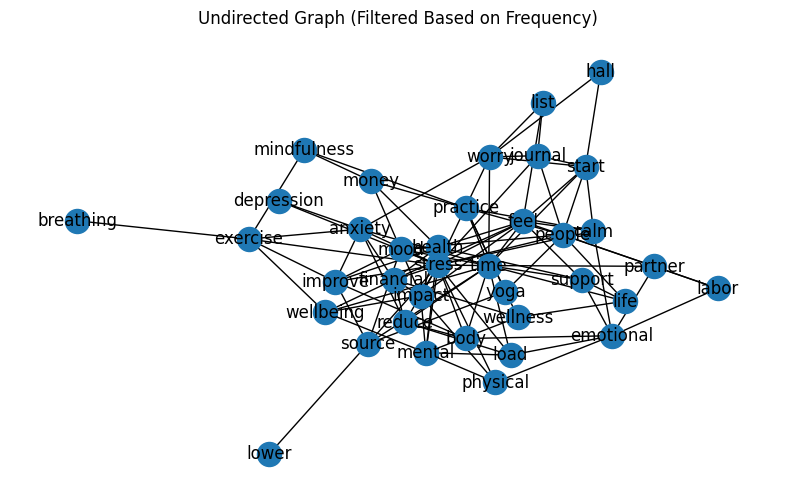

In [65]:
# Plot Undirected Graph
plt.figure(figsize=(10, 6))
plt.title('Undirected Graph (Filtered Based on Frequency)')
nx.draw_networkx(F, with_labels=True, node_size=300, arrowstyle='-|>', arrowsize=10)
plt.axis('off')
plt.show()

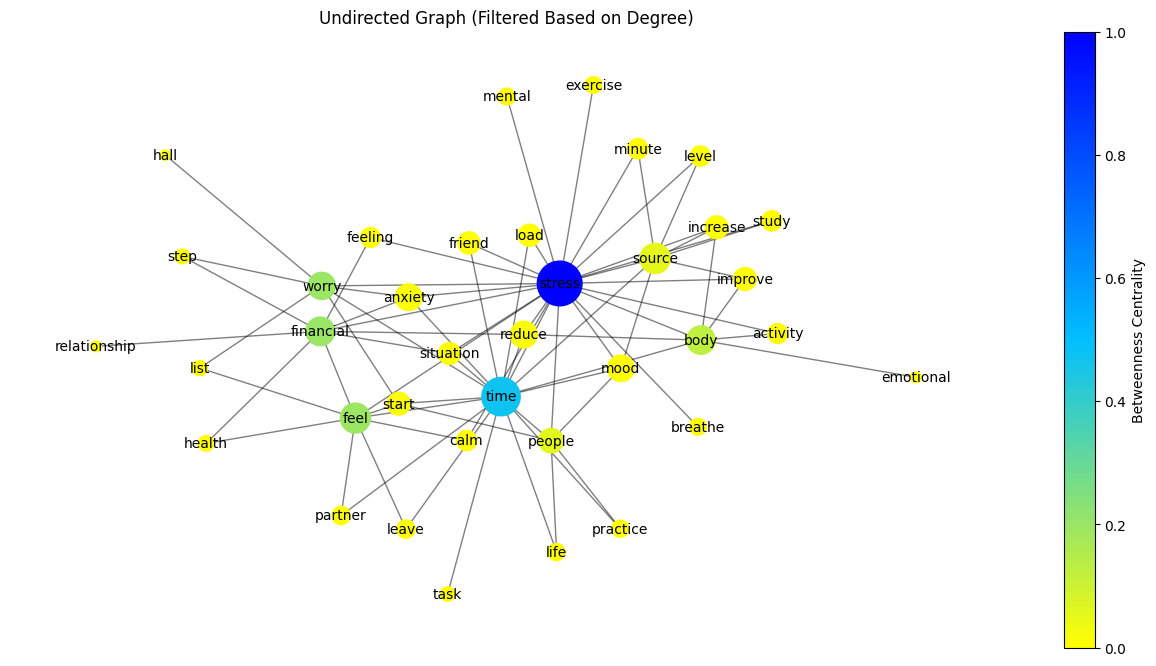

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# calculate betweenness and eigenvector centrality
betweenness = nx.betweenness_centrality(H_u)
eigenvector_centrality = nx.eigenvector_centrality(H_u)

# colors
colors = ["yellow", "deepskyblue", "blue"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# position
pos = nx.spring_layout(H_u)

# plotting
plt.figure(figsize=(16, 8))
# nodes
node_size = [eigenvector_centrality[node] * 2000 for node in H_u.nodes()]
node_color = [betweenness[node] for node in H_u.nodes()]
nx.draw_networkx_nodes(H_u, pos, node_size=node_size, node_color=node_color, cmap=cmap)

# edges
nx.draw_networkx_edges(H_u, pos, alpha=0.5)

# labels
labels = {node: node for node in H_u.nodes()}
nx.draw_networkx_labels(H_u, pos, labels, font_size=10)
plt.title('Undirected Graph (Filtered Based on Degree)')
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca(), orientation='vertical', label='Betweenness Centrality')
plt.axis('off')
plt.show()


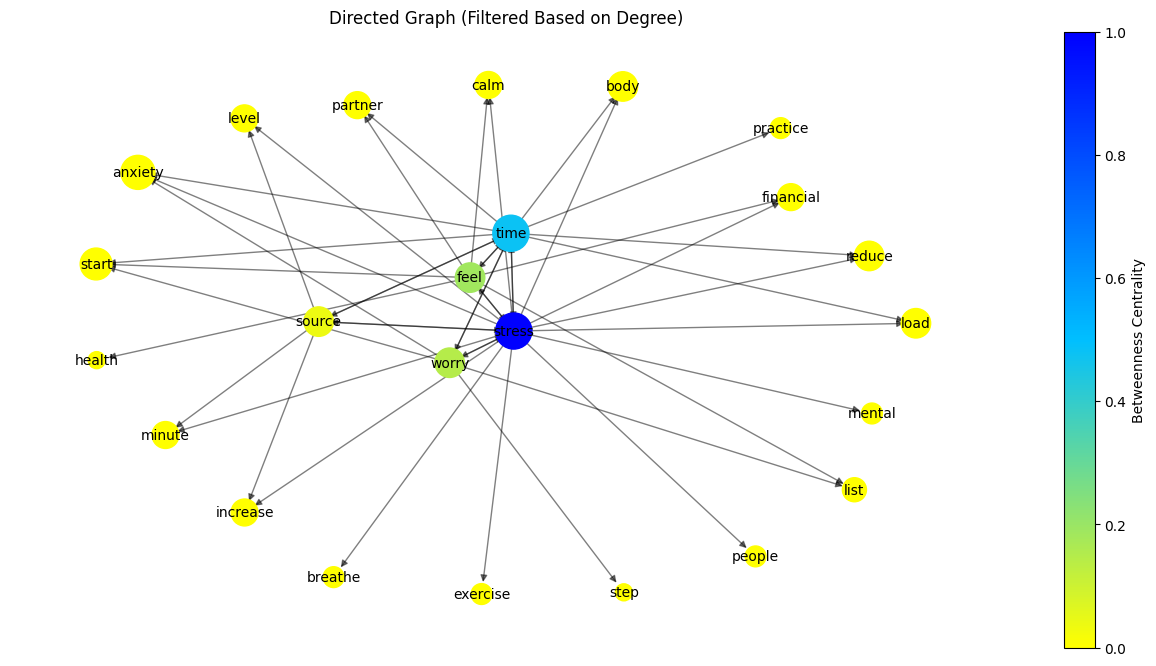

In [67]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# calculate betweenness and eigenvector centrality
betweenness = nx.betweenness_centrality(H)
eigenvector_centrality = nx.eigenvector_centrality(H)

# color
colors = ["yellow", "deepskyblue", "blue"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# position
pos = nx.spring_layout(H)

# plotting
plt.figure(figsize=(16, 8))
# nodes
node_size = [eigenvector_centrality[node] * 2000 for node in H.nodes()]  # 节点大小与特征向量中心性相关
node_color = [betweenness[node] for node in H.nodes()]  # 颜色与介数中心性相关
nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color=node_color, cmap=cmap)

# edge
nx.draw_networkx_edges(H, pos, alpha=0.5)

# labels
labels = {node: node for node in H.nodes()}
nx.draw_networkx_labels(H, pos, labels, font_size=10)
plt.title('Directed Graph (Filtered Based on Degree)')
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca(), orientation='vertical', label='Betweenness Centrality')
plt.axis('off')
plt.show()


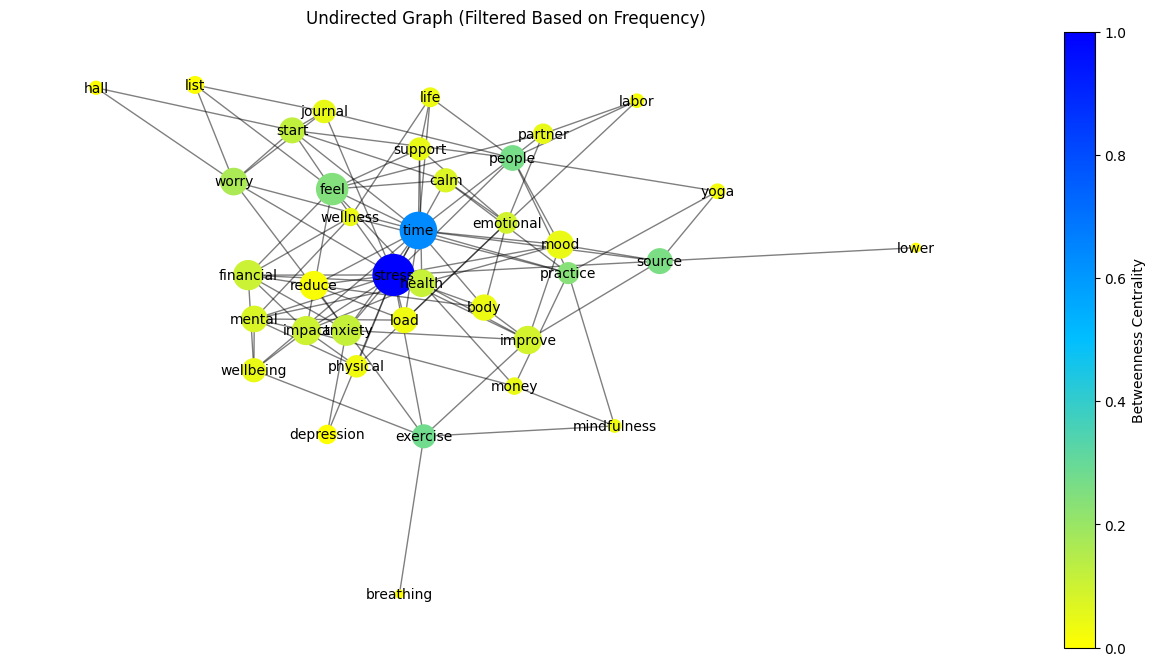

In [68]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# calculate betweenness and eigenvector centrality
betweenness = nx.betweenness_centrality(F)
eigenvector_centrality = nx.eigenvector_centrality(F)

# color
colors = ["yellow", "deepskyblue", "blue"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# position
pos = nx.spring_layout(F)

# plot
plt.figure(figsize=(16, 8))
# node
node_size = [eigenvector_centrality[node] * 2000 for node in F.nodes()]  # 节点大小与特征向量中心性相关
node_color = [betweenness[node] for node in F.nodes()]  # 颜色与介数中心性相关
nx.draw_networkx_nodes(F, pos, node_size=node_size, node_color=node_color, cmap=cmap)

# edge
nx.draw_networkx_edges(F, pos, alpha=0.5)

# label
labels = {node: node for node in F.nodes()}
nx.draw_networkx_labels(H, pos, labels, font_size=10)
plt.title('Undirected Graph (Filtered Based on Frequency)')
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca(), orientation='vertical', label='Betweenness Centrality')
plt.axis('off')
plt.show()


In [69]:
def top_five_centrality(graph):
    betweenness = nx.betweenness_centrality(graph)
    eigenvector = nx.eigenvector_centrality(graph)
    # 转换为 DataFrame
    df_betweenness = pd.DataFrame(betweenness.items(), columns=['Node', 'Betweenness']).nlargest(5, 'Betweenness')
    df_eigenvector = pd.DataFrame(eigenvector.items(), columns=['Node', 'Eigenvector']).nlargest(5, 'Eigenvector')
    # 合并两个 DataFrame
    df = pd.concat([df_betweenness.reset_index(drop=True), df_eigenvector.reset_index(drop=True)], axis=1)
    return df

# top 5 centrality
top_H = top_five_centrality(H)
top_Hu = top_five_centrality(H_u)
top_F = top_five_centrality(F)

# results
print(top_H)
print("\n")
print(top_Hu)
print("\n")
print(top_F)

     Node  Betweenness     Node  Eigenvector
0  stress     0.078063   stress     0.337764
1    time     0.037220     time     0.337764
2    feel     0.014493  anxiety     0.300234
3   worry     0.011528    start     0.262705
4  source     0.002964     body     0.225176


        Node  Betweenness       Node  Eigenvector
0     stress     0.550967     stress     0.516852
1       time     0.258859       time     0.381328
2  financial     0.110461     source     0.235413
3      worry     0.107778       feel     0.231979
4       feel     0.106107  financial     0.210700


       Node  Betweenness       Node  Eigenvector
0    stress     0.278389     stress     0.432386
1      time     0.178184       time     0.340327
2  exercise     0.077981       feel     0.249786
3    people     0.074108    anxiety     0.226834
4    source     0.072606  financial     0.216958


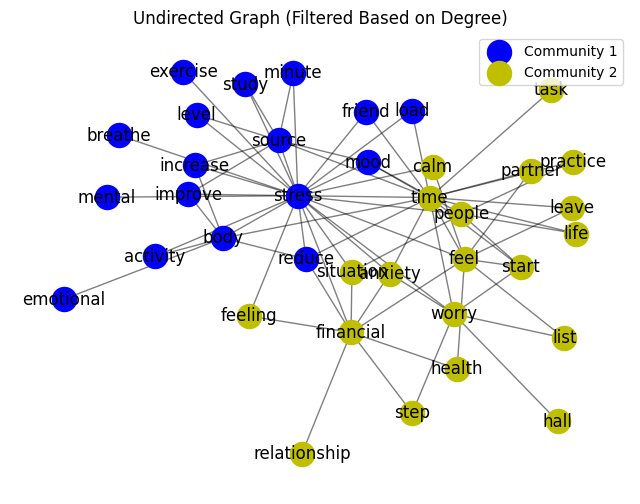

Community 1: stress, friend, load, activity, increase, breathe, body, exercise, mental, improve, reduce, emotional, source, study, level, minute, mood
Community 2: life, task, start, leave, people, health, situation, anxiety, relationship, feel, worry, partner, step, feeling, time, list, financial, calm, practice, hall


In [70]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import itertools

comp = community.girvan_newman(H_u)

# communities
k = 3  # assume we want 3
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
communities = next(limited)

# plot communities
pos = nx.spring_layout(H_u)
colors = ['b', 'y', 'c', 'm' , 'k']  # color inventory
plt.figure(figsize=(8, 6))

labels = {node: str(node) for node in H_u.nodes()}

cluster_degrees = []
for i, community_nodes in enumerate(communities):
    nx.draw_networkx_nodes(H_u, pos, nodelist=community_nodes, node_color=colors[i], label=f'Community {i+1}')
    cluster_degrees.append([(node, H_u.degree[node]) for node in community_nodes])

nx.draw_networkx_edges(H_u, pos, alpha=0.5)
nx.draw_networkx_labels(H_u, pos, labels=labels)  # labels
plt.legend()
plt.title('Undirected Graph (Filtered Based on Degree)')
plt.axis('off')
plt.show()

for i, community_nodes in enumerate(communities):
    nodes_list = ', '.join([str(node) for node in community_nodes])
    print(f'Community {i+1}: {nodes_list}')

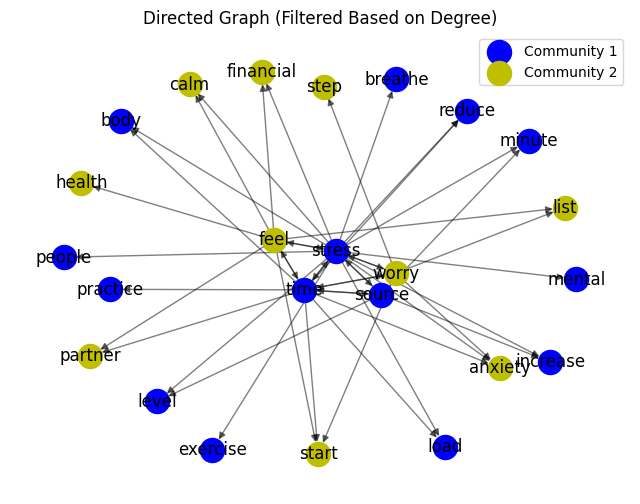

Community 1: stress, time, load, increase, people, breathe, body, exercise, mental, reduce, practice, source, level, minute
Community 2: feel, list, financial, calm, health, worry, partner, anxiety, step, start


In [71]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import itertools

comp = community.girvan_newman(H)

# communities
k = 3  # assume we want 3
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
communities = next(limited)

# plot communities
pos = nx.spring_layout(H)
colors = ['b', 'y', 'c', 'm', 'k']  # colors
plt.figure(figsize=(8, 6))

labels = {node: str(node) for node in H.nodes()}

cluster_degrees = []
for i, community_nodes in enumerate(communities):
    nx.draw_networkx_nodes(H, pos, nodelist=community_nodes, node_color=colors[i], label=f'Community {i+1}')
    cluster_degrees.append([(node, H.degree[node]) for node in community_nodes])

nx.draw_networkx_edges(H, pos, alpha=0.5)
nx.draw_networkx_labels(H, pos, labels=labels)  # text labels
plt.legend()
plt.title('Directed Graph (Filtered Based on Degree)')
plt.axis('off')
plt.show()

for i, community_nodes in enumerate(communities):
    nodes_list = ', '.join([str(node) for node in community_nodes])
    print(f'Community {i+1}: {nodes_list}')

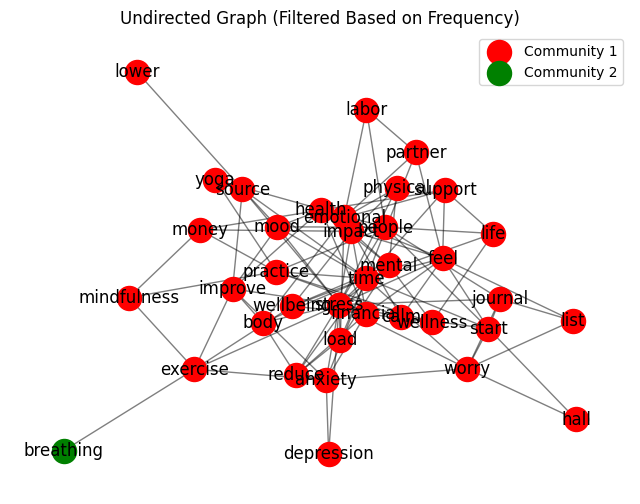

Community 1: yoga, life, journal, money, improve, emotional, source, wellness, mindfulness, start, stress, people, mental, body, health, reduce, exercise, anxiety, support, load, feel, depression, lower, worry, partner, impact, time, list, financial, calm, practice, labor, hall, physical, mood, wellbeing
Community 2: breathing


In [78]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import itertools

comp = community.girvan_newman(F)


k = 4
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
communities = next(limited)

# 绘制社区
pos = nx.spring_layout(F)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
plt.figure(figsize=(8, 6))

labels = {node: str(node) for node in F.nodes()}

cluster_degrees = []
for i, community_nodes in enumerate(communities):
    nx.draw_networkx_nodes(F, pos, nodelist=community_nodes, node_color=colors[i], label=f'Community {i+1}')
    cluster_degrees.append([(node, F.degree[node]) for node in community_nodes])

nx.draw_networkx_edges(F, pos, alpha=0.5)
nx.draw_networkx_labels(F, pos, labels=labels)  # labels
plt.legend()
plt.title('Undirected Graph (Filtered Based on Frequency)')
plt.axis('off')
plt.show()

for i, community_nodes in enumerate(communities):
    nodes_list = ', '.join([str(node) for node in community_nodes])
    print(f'Community {i+1}: {nodes_list}')

In [73]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

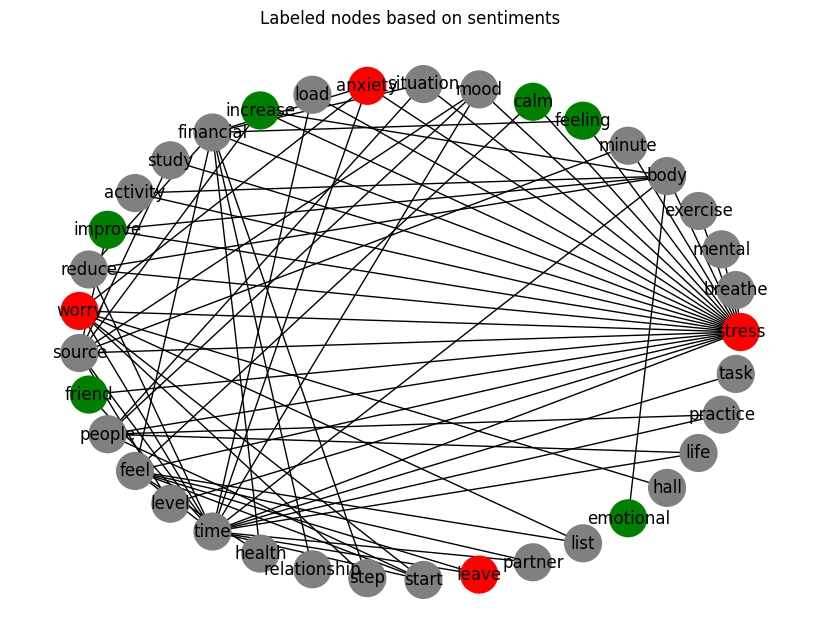

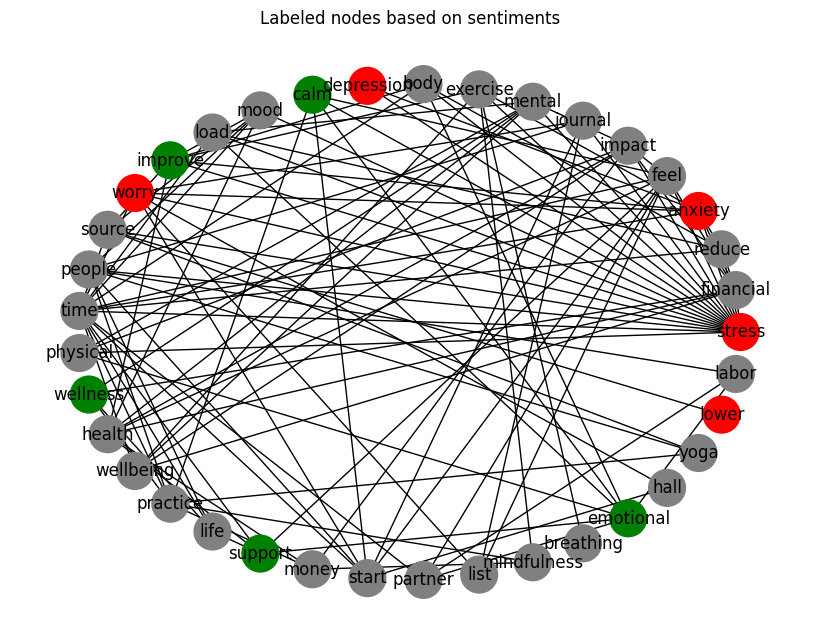

In [74]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def sentiplot(G):
  Hsenti=G
  Hnode=Hsenti.nodes
  #print(Hnode)
  scores=[]
  for node in Hnode:
    sentiscore = sid.polarity_scores(node)['compound']
    if sentiscore == 0:
      Hsenti.nodes[node]["emo"]="neutral"
    elif sentiscore>0:
      Hsenti.nodes[node]["emo"]="positive"
    else:
      Hsenti.nodes[node]["emo"]="negative"
    scores.append(sid.polarity_scores(node)['compound'])
  # sentiment scores
  #print(scores)
  for node, attrs in Hsenti.nodes(data=True):
      emo = attrs.get('emo', None)  # Using get to avoid KeyError if the attribute is missing
      #print(f"Node {node} has an emotion of {emo}")
  #plot based on sentiment
  # Mapping from categories to colors
  color_map = {
      'neutral': 'gray',
      'positive': 'green',
      'negative': 'red'
  }

  # Set positions manually based on label for clarity in clustering
  #pos = nx.spring_layout(Hsenti, k=0.5, iterations=20)
  # Use spring layout as a base
  pos = nx.circular_layout(Hsenti)
  '''
  pos = nx.spring_layout(Hsenti, seed=42)

  # Adjust positions to cluster by attribute
  cluster_centers = {
      'neutral': np.array([0.5, 0.5]),
      'positive': np.array([0.1, 0.1]),
      'negative': np.array([0.9, 0.9])
  }

  for node in Hsenti.nodes:
      sentiment = Hsenti.nodes[node]['emo']
      # Move node position towards the cluster center for its sentiment
      pos[node] += 0.1 * (cluster_centers[sentiment] - pos[node])
  '''

  node_colors = [color_map[Hsenti.nodes[node]['emo']] for node in Hsenti]

  # Draw the graph
  plt.figure(figsize=(8, 6))
  nx.draw(Hsenti, pos, with_labels=True, node_color = node_colors, node_size=700)
  plt.title('Labeled nodes based on sentiments')
  plt.show()

sentiplot(H_u)
sentiplot(F)
